# Analyze Data of Linear Programming

In [1]:
# load libraries and setting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.dataloader import DataLoader
from src.solver import solve_lp

dataloader = DataLoader()
variables, A, B, L = dataloader.load()

In [20]:
# Load result data
result = []
with open('result_status.txt') as f:
    for l in f.readlines():
        result.append(l.strip().split('\t'))
    
_result = [rs[:-1] for rs in result]

status_df = pd.DataFrame(_result[1:], columns = result[0])
status_df.set_index("prob_num", inplace = True)

status_df.loc[:, 'primal_objective':] = status_df.loc[:, 'primal_objective':].replace("None", np.nan).astype(float)
status_df.index = list(map(int, status_df.index))

C:\Users\wklee\AppData\Local\Temp\ipykernel_9264\2003374007.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  status_df.loc[:, 'primal_objective':] = status_df.loc[:, 'primal_objective':].replace("None", np.nan).astype(float)


## Solving Linear programming

풀리지 않는 문제를 풀기 위한 노력들.  

- Variables
- Solver

### Variables

#### The number of Variables affect optimal?  

variable 수가 optimal solve에 영향을 주는가?

In [21]:
result_weights = []
with open('result_weights.txt') as f:
    for l in f.readlines():
        result_weights.append(l.strip().split('\t'))

In [22]:
invest_dummy = pd.DataFrame(index=range(80000), columns=range(3000), dtype=float)

for i, var_idx_list in enumerate(variables):
    invest_dummy.loc[i, var_idx_list] = 1
    
var_nums = invest_dummy.sum(axis=1)
status_df['var_counts'] = var_nums

In [23]:
# number of variables of problems which have "OPTIMAL" solution
status_df[status_df['status'] == 'optimal']['var_counts'].describe()

count    24619.000000
mean      1715.783338
std        121.750618
min       1180.000000
25%       1631.000000
50%       1729.000000
75%       1816.000000
max       1946.000000
Name: var_counts, dtype: float64

In [24]:
# number of variables of problems which doesn't have solution
status_df[status_df['status'] != 'optimal']['var_counts'].describe()

count    55381.000000
mean       914.478558
std        443.966143
min          1.000000
25%        567.000000
50%        975.000000
75%       1288.000000
max       1875.000000
Name: var_counts, dtype: float64

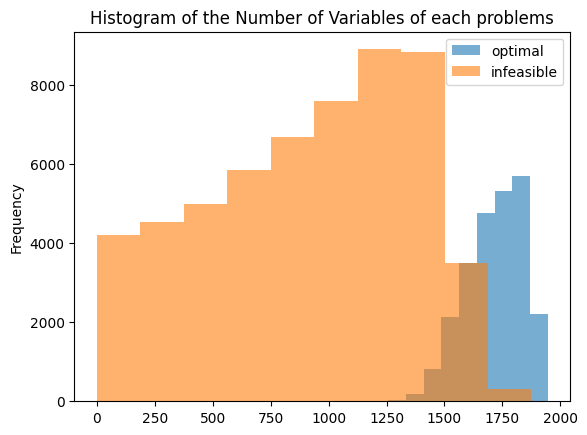

In [25]:
status_df[status_df['status'] == 'optimal']['var_counts'].plot(kind='hist', alpha=0.6)
status_df[status_df['status'] != 'optimal']['var_counts'].plot(kind='hist', alpha=0.6)

plt.title("Histogram of the Number of Variables of each problems")
plt.legend(['optimal', 'infeasible'])
plt.show()

변수의 수가 적을 수록 문제가 잘 안 풀리며,  
심지어 1180개 미만의 변수를 가진 문제는 전부 optimal이 존재하지 않는다.    

해볼만한 것
- 특정 변수가 포함됐을 때 문제가 잘 안풀렸는가  
- 요구수익률 (약 9%) 를 만족하는 조합이 안나오는 것인지

#### Specific Variable affect solution?

<Axes: >

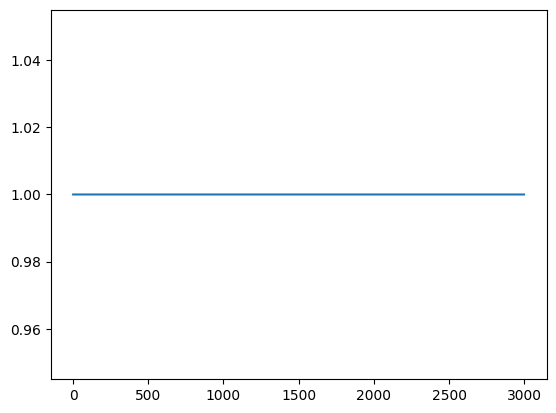

In [26]:
solved_idx = list(map(int, status_df[status_df['status'] == 'optimal'].index))
unsolved_idx = list(map(int, status_df[status_df['status'] != 'optimal'].index))

vars_have_optimal_solution = invest_dummy.loc[solved_idx].isna().any(axis=0) 
vars_have_optimal_solution.astype(int).plot()

특정 변수 하나가 optimal solution을 가지지 못하게 하진 않음.  

<Axes: >

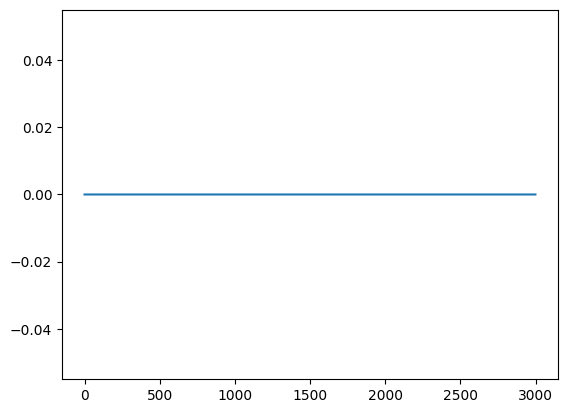

In [34]:
# Should we contain specific variable for solving LP?  
vars_noptimal = invest_dummy.loc[unsolved_idx].isna().all(axis=0)
vars_noptimal.astype(int).plot()

반대로, 특정 변수 하나가 LP를 풀게 만들지 않음

#### Satisfing IRR?

In [62]:
cpreturns = dataloader.get_matrix_cp_return()
mean_rtn = pd.Series(cpreturns, index=range(3000))

# maximum return is under the constraint
irr_feasible_unsolved = (invest_dummy.loc[unsolved_idx] * mean_rtn).max(axis=1)
irr_feasible_unsolved = irr_feasible_unsolved < 0.0963007951203275  
irr_feasible_unsolved.sum()

np.int64(47)

In [63]:
# maximum return is under the constraint
irr_feasible_solved = (invest_dummy.loc[solved_idx] * mean_rtn).max(axis=1)
irr_feasible_solved = irr_feasible_solved < 0.0963007951203275  
irr_feasible_solved.sum()

np.int64(0)

infeasible 문제들 중  
선택된 변수들 가운데 가장 큰 return이 포트폴리오의 최소 요구 return 인 9\% 가량을  
넘지 못하는 경우가 약 47개. 
(최대 return을 가지는 자산에 100%로 투자해도 최적화 문제 풀이 자체가 불가능)    

그럼 IRR을 포함해  
다른 조건들을 만족하면서 


$$
\begin{align}
&\min_{\mathbf{x}} \quad & -\mu \mathbf{x}  \\

&\text{subject to } & \mathbf{1}' \mathbf{x} \le 1 \\
& & -\mathbf{1}' \mathbf{x} \le -1 \\
& & 0 \le x_i \le 2 x_i^{0}
\end{align}
$$

In [105]:
from cvxopt import solvers, matrix, sparse

upper_bound_list = dataloader.get_point_2x0().copy()

L2 = matrix(-mean_rtn.values.reshape(-1, 1))
A2 = sparse(matrix(np.concatenate([np.ones((1, 3000)), 
                                   -np.ones((1, 3000)), 
                                   -np.eye(3000), 
                                   np.eye(3000)], axis=0)))
B2 = matrix([1, -1, matrix(np.zeros((3000, 1))), matrix(upper_bound_list)])

In [136]:
from tqdm import tqdm 

# Check problem can be solved  
with open("result_infeasible_test.txt", 'w') as f:
    f.write("\t".join(['prob_num', 'max_return']) + "\n")
    
    for idx in tqdm(unsolved_idx):
        used_vars = variables[idx]
        
        used_const = [0, 1]
        for j in used_vars:
            used_const.append(j+2)
            used_const.append(j+3002)
            
        opt = solvers.lp(L2[used_vars], A2[used_const, used_vars], B2[used_const], solver='glpk')
        
        if opt['status'] == 'optimal':
            maximum_rtn = np.dot(opt['x'].T, mean_rtn[used_vars].values)[0]
        else:
            maximum_rtn = -1
        
        f.write("\t".join(map(str, [idx, maximum_rtn])) + "\n")

  4%|▎         | 1987/55381 [01:43<46:23, 19.18it/s]  


KeyboardInterrupt: 

### Solvers

#### Any other method to solve linear programming?  

Is 'glpk' the best solver?  
`glpk` 로 풀리지 않는 문제들을 다른 solver로 풀 수 있는가?

In [24]:
unsolved = status_df[status_df['status'] != 'optimal']
unsolved_nums = unsolved.index
unsolved_nums = list(map(int, unsolved_nums))

solve_lp((unsolved_nums[1], variables[unsolved_nums[1]]), L, A, B, solver='')

     pcost       dcost       gap    pres   dres   k/t
 0: -6.0515e-01 -2.3752e+01  8e+04  4e+01  1e+00  1e+00
 1: -3.2533e+01 -3.4414e+01  9e+03  3e+00  1e-01  1e-01
 2: -3.8906e+00 -3.7983e+00  1e+02  4e-01  1e-02  3e-01
 3: -2.1856e+00 -2.1588e+00  4e+01  2e-01  5e-03  1e-01
 4: -1.7227e+00 -1.7070e+00  2e+01  1e-01  4e-03  8e-02
 5: -9.7424e-01 -9.7370e-01  4e+00  3e-02  1e-03  2e-02
 6: -6.5446e-01 -6.5579e-01  4e-01  7e-03  2e-04  3e-03
 7: -5.8381e-01 -5.8427e-01  9e-02  2e-03  7e-05  8e-04
 8: -5.8611e-01 -5.8656e-01  1e-01  2e-03  7e-05  8e-04
 9: -5.8558e-01 -5.8604e-01  9e-02  2e-03  7e-05  8e-04
10: -5.8568e-01 -5.8619e-01  9e-02  2e-03  7e-05  7e-04
11: -5.8186e-01 -5.8244e-01  8e-02  2e-03  6e-05  4e-04
12: -5.7206e-01 -5.7250e-01  4e-02  1e-03  4e-05  2e-04
13: -5.7150e-01 -5.7193e-01  4e-02  1e-03  3e-05  2e-04
14: -5.6561e-01 -5.6592e-01  3e-02  7e-04  2e-05  7e-05
15: -5.5857e-01 -5.5870e-01  9e-03  2e-04  8e-06  1e-05
16: -5.5685e-01 -5.5693e-01  6e-03  1e-04  5e-06  

(48,
 {'x': <1684x1 matrix, tc='d'>,
  'y': <0x1 matrix, tc='d'>,
  's': <3371x1 matrix, tc='d'>,
  'z': <3371x1 matrix, tc='d'>,
  'status': 'unknown',
  'gap': 1.0726946383949553e+163,
  'relative gap': 1.927946792796755e+163,
  'primal objective': -0.55639224194505,
  'dual objective': 6.892201872843792e+159,
  'primal infeasibility': 0.0,
  'dual infeasibility': 6.936502448639551e+156,
  'primal slack': 1.564302224159137e-07,
  'dual slack': 3.4028234663852886e+38,
  'residual as primal infeasibility certificate': 0.0010064276375841962,
  'residual as dual infeasibility certificate': 0.0,
  'iterations': 100,
  'elapsed': 12.774795055389404,
  'prob_num': 48})

In [22]:
solve_lp((unsolved_nums[0], variables[unsolved_nums[0]]), L, A, B, solver='dsdp')

     pcost       dcost       gap    pres   dres   k/t
 0: -5.9715e-01 -2.1100e+01  6e+04  4e+01  1e+00  1e+00
 1: -2.6380e+01 -2.8117e+01  6e+03  3e+00  1e-01  4e-02
 2: -3.0422e+00 -3.0743e+00  1e+02  4e-01  1e-02  2e-01
 3: -1.7367e+00 -1.7558e+00  3e+01  1e-01  5e-03  6e-02
 4: -1.3893e+00 -1.4042e+00  2e+01  1e-01  3e-03  4e-02
 5: -8.8946e-01 -8.9702e-01  4e+00  4e-02  1e-03  1e-02
 6: -6.0132e-01 -6.0394e-01  5e-01  8e-03  3e-04  2e-03
 7: -6.2555e-01 -6.2818e-01  9e-01  1e-02  4e-04  3e-03
 8: -6.2362e-01 -6.2651e-01  8e-01  1e-02  3e-04  3e-03
 9: -6.1805e-01 -6.2067e-01  9e-01  1e-02  3e-04  3e-03
10: -6.1440e-01 -6.1675e-01  1e+00  9e-03  3e-04  3e-03
11: -6.1491e-01 -6.1729e-01  1e+00  9e-03  3e-04  3e-03
12: -6.1521e-01 -6.1772e-01  1e+00  9e-03  3e-04  3e-03
13: -6.1104e-01 -6.1336e-01  1e+00  9e-03  3e-04  3e-03
14: -6.0256e-01 -6.0396e-01  2e+00  8e-03  3e-04  3e-03
15: -5.8126e-01 -5.5713e-01  2e+01  6e-03  2e-04  3e-02
16: -5.8156e-01  2.0798e+00  2e+03  6e-03  2e-04  

(36,
 {'x': None,
  'y': <0x1 matrix, tc='d'>,
  's': None,
  'z': <2885x1 matrix, tc='d'>,
  'status': 'primal infeasible',
  'gap': None,
  'relative gap': None,
  'primal objective': None,
  'dual objective': 1.0,
  'primal infeasibility': None,
  'dual infeasibility': None,
  'primal slack': None,
  'dual slack': 7.226041475423295,
  'residual as primal infeasibility certificate': 2.6224935137604318e-08,
  'residual as dual infeasibility certificate': None,
  'iterations': 20,
  'elapsed': 2.556706666946411,
  'prob_num': 36})

## Analysing Solved problems data

In [23]:
# How many problems solved?
status_df['status']

status
primal infeasible    55381
optimal              24619
Name: count, dtype: int64

<Axes: title={'center': 'Histogram of elapsed time for solving LP'}, ylabel='Frequency'>

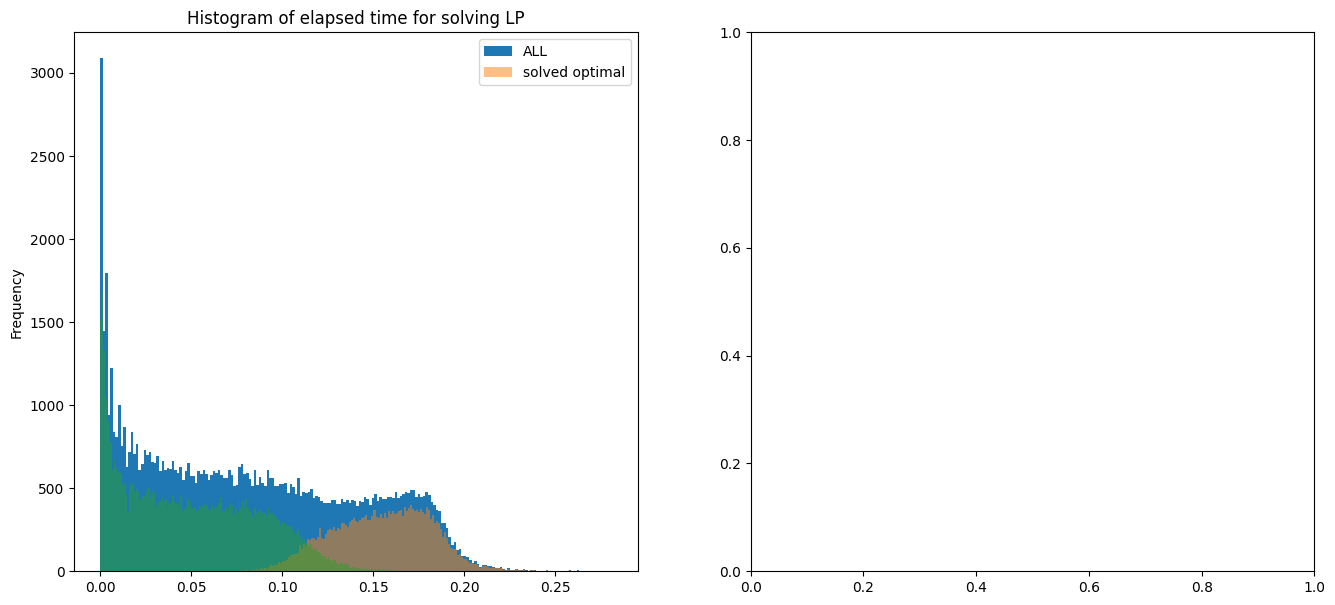

In [98]:
# How much time spent on solving problems
row, col = 1, 2
fig, ax = plt.subplots(row, col, figsize=(16, 7))

status_df['elapsed'].plot(kind='hist', bins=200, ax=ax[0])
status_df.query("status == 'optimal'")['elapsed'].plot(kind='hist', bins=200, ax=ax[0], alpha=0.5)
ax[0].legend(["ALL", "solved optimal"])
ax[0].set_title("Histogram of elapsed time for solving LP")

status_df.query("status == 'primal infeasible'")['elapsed'].plot(kind='hist', bins=200, ax=ax[0], alpha=0.5)

Text(0.5, 1.0, 'The number of problem solved while problem are being solved')

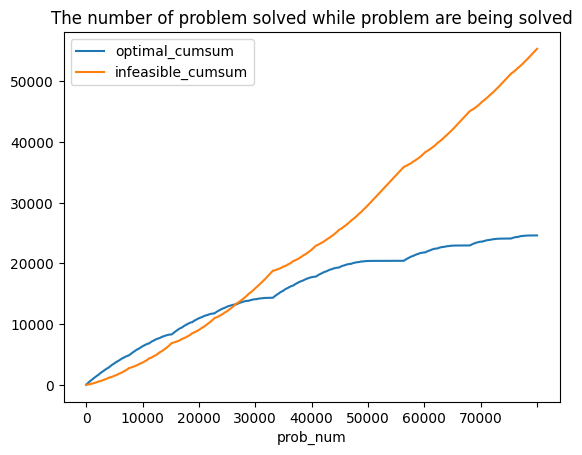

In [99]:
# Is it different solving status when computer have much burden? (The more problem solved, the difficult computer solve problem)
solved_st_df = status_df[['status']].copy()
solved_st_df['optimal'] = (solved_st_df['status'] == 'optimal') * 1
solved_st_df['infeasible'] = (solved_st_df['status'] == 'primal infeasible') * 1

solved_st_df['optimal_cumsum'] = solved_st_df['optimal'].cumsum()
solved_st_df['infeasible_cumsum'] = solved_st_df['infeasible'].cumsum()

solved_st_df[['optimal_cumsum', 'infeasible_cumsum']].plot()
plt.title("The number of problem solved while problem are being solved")

## TO-DO  

optimal한 답이 안 나온 비율이 너무 많음.  
그게 문제를 많이 풀 수록 특히 그렇진 않아보임.  


- LP를 풀 때 다른 알고리즘을 사용해 문제를 풀기  
    - 전체를 다른 알고리즘으로 다시 풀기
    - 풀지 못한 문제만 다른 알고리즘으로 풀기  

- 지금 나온 답은 robust 한가?
    - 다시 코드를 돌렸을 때 optimal/infeasible 수가 같게 나오는가?
    - optimal한 x가 달라지지 않는가?